In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-20 17:19:10--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: 'course_lead_scoring.csv.2'

     0K .......... .......... .......... .......... .......... 63% 2.51M 0s
    50K .......... .......... ........                        100% 2.68M=0.03s

2025-10-20 17:19:10 (2.57 MB/s) - 'course_lead_scoring.csv.2' saved [80876/80876]



In [3]:
df = pd.read_csv('course_lead_scoring.csv')

In [4]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


Data preparation

In [5]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

In [6]:
categorical_columns

['lead_source', 'industry', 'employment_status', 'location']

In [7]:
df[categorical_columns] = df[categorical_columns].fillna('NA')

In [8]:
numeric_col_names = df.select_dtypes(include=np.number).columns.tolist()

In [9]:
df[numeric_col_names] = df[numeric_col_names].fillna(0)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [13]:
numeric_col_names = numeric_col_names[:-1]

In [14]:
for c in numeric_col_names:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print(f"c: {c} , roc : {auc}")

c: number_of_courses_viewed , roc : 0.7635680590007088
c: annual_income , roc : 0.5519578313253012
c: interaction_count , roc : 0.738270176293409
c: lead_score , roc : 0.6144993577250176


Answer: number_of_courses_viewed

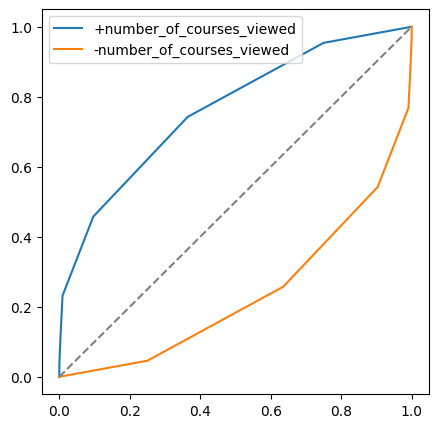

In [15]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.number_of_courses_viewed)
plt.plot(fpr, tpr, label='+number_of_courses_viewed')

fpr, tpr, _ = roc_curve(y_train, -df_train.number_of_courses_viewed)
plt.plot(fpr, tpr, label='-number_of_courses_viewed')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

In [16]:
import seaborn as sns

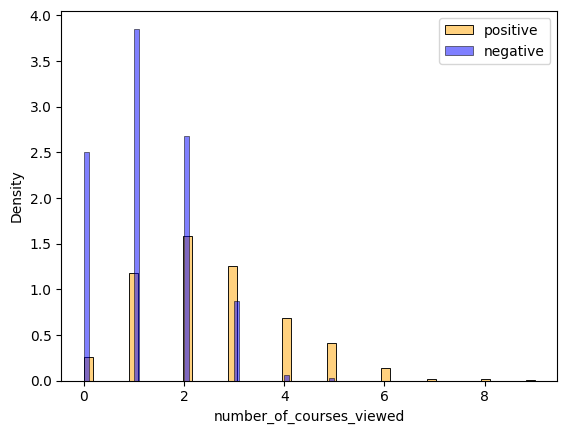

In [17]:
sns.histplot(df_train.number_of_courses_viewed[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(df_train.number_of_courses_viewed[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

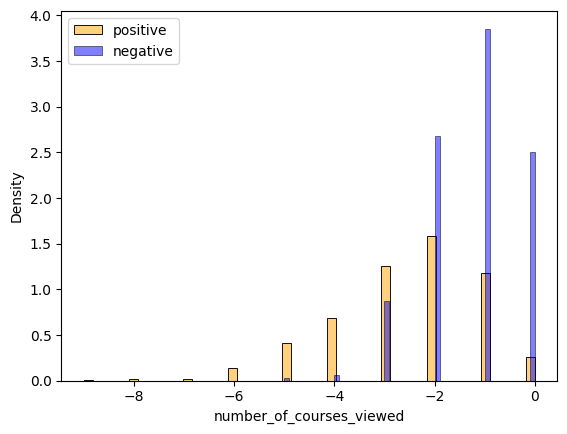

In [18]:
sns.histplot(-df_train.number_of_courses_viewed[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(-df_train.number_of_courses_viewed[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

In [19]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [21]:
X_train_num = df_train[numeric_col_names].values

In [22]:

scaler = StandardScaler()

In [23]:
X_train_num = scaler.fit_transform(X_train_num)

In [24]:
ohe = OneHotEncoder( handle_unknown='ignore')
X_train_cat = ohe.fit_transform(df_train[categorical_columns].values)

In [25]:
X_train = np.column_stack([X_train_num, X_train_cat.toarray()])

In [26]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [27]:
X_val_num = df_val[numeric_col_names].values
X_val_num = scaler.transform(X_val_num)

X_val_cat = ohe.transform(df_val[categorical_columns].values)

X_val = np.column_stack([X_val_num, X_val_cat.toarray()])

In [28]:
y_pred = model.predict_proba(X_val)[:, 1]

In [29]:
roc_auc_score(y_val, y_pred)

0.920956763493433

In [30]:
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.8367126833477136

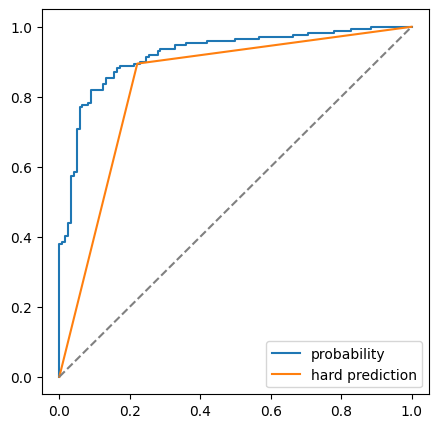

In [31]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

In [32]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [33]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

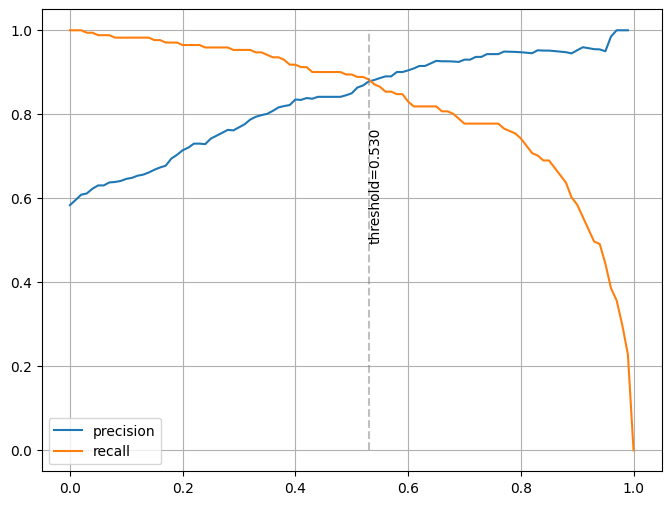

Precision and recall intersect at threshold = 0.530


In [64]:

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

# Find intersection point
idx_closest = np.argmin(np.abs(df_scores.p - df_scores.r))
threshold_intersection = df_scores.threshold[idx_closest]

plt.vlines(threshold_intersection, 0, 1, color='grey', linestyle='--', alpha=0.5)
plt.text(threshold_intersection, 0.5, f'threshold={threshold_intersection:.3f}', rotation=90)

plt.legend()
plt.grid(True)
plt.show()

print(f"Precision and recall intersect at threshold = {threshold_intersection:.3f}")

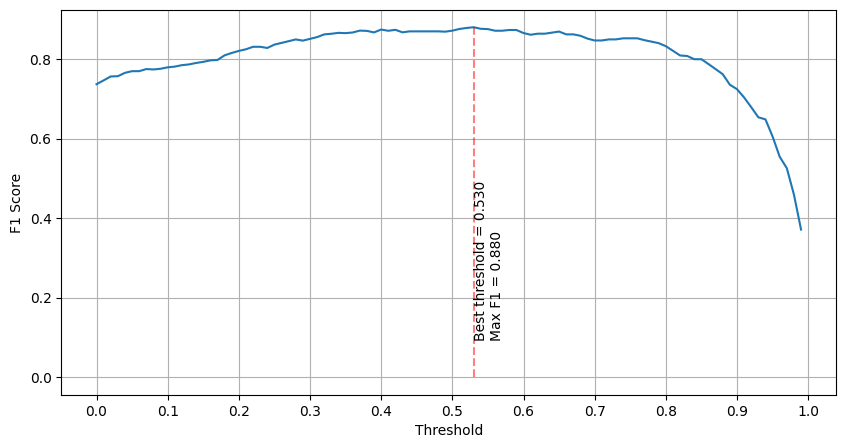

In [66]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)
best_threshold = df_scores.loc[df_scores.f1.idxmax(), 'threshold']
max_f1 = df_scores.f1.max()

plt.figure(figsize=(10, 5))
plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(best_threshold, 0, max_f1, color='red', linestyle='--', alpha=0.5)
plt.text(best_threshold, 0.1, f'Best threshold = {best_threshold:.3f}\nMax F1 = {max_f1:.3f}', rotation=90)

plt.xticks(np.linspace(0, 1, 11))
plt.ylabel('F1 Score')
plt.xlabel('Threshold')
plt.grid(True)
plt.show()

In [38]:
df_scores['f1'].max()

np.float64(0.880466472303207)

In [39]:
from sklearn.model_selection import KFold

In [46]:
columns = categorical_columns

In [53]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

def train(df_train, y_train, C=1.0):
    # Identify numeric and categorical columns
    numeric_cols = df_train.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = df_train.select_dtypes(include='object').columns.tolist()

    # Scale numeric features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(df_train[numeric_cols].values)

    # DictVectorizer for categorical features
    dicts = df_train[categorical_cols].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train_cat = dv.fit_transform(dicts)

    # Combine numeric and categorical features
    X_train = np.column_stack([X_train_num, X_train_cat])

    model = LogisticRegression(solver='liblinear', max_iter=1000, C=C)
    model.fit(X_train, y_train)

    return scaler, dv, model, numeric_cols, categorical_cols

def predict(df, scaler, dv, model, numeric_cols, categorical_cols):
    X_num = scaler.transform(df[numeric_cols].values)
    dicts = df[categorical_cols].to_dict(orient='records')
    X_cat = dv.transform(dicts)
    X = np.column_stack([X_num, X_cat])
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [ ]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx].copy()
    df_val = df_full_train.iloc[val_idx].copy()

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    # Remove target from features
    del df_train['converted']
    del df_val['converted']

    scaler, dv, model, numeric_cols, categorical_cols = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, scaler, dv, model, numeric_cols, categorical_cols)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)



AUC scores for each fold: [0.9211642968808159, 0.9322073657049028, 0.9071076706544686, 0.910958904109589, 0.9321312490326575]
Mean AUC: 0.921 +- 0.010


In [57]:
def train_no_scaler(df_train, y_train, C=1.0):
    # Convert all columns to categorical using DictVectorizer
    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', max_iter=1000, C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict_no_scaler(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

# Cross-validation without scaling
scores_no_scaler = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx].copy()
    df_val = df_full_train.iloc[val_idx].copy()

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    del df_train['converted']
    del df_val['converted']

    dv, model = train_no_scaler(df_train, y_train, C=1.0)
    y_pred = predict_no_scaler(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores_no_scaler.append(auc)

# For the version with StandardScaler
print('Mean AUC: %.3f ± %.3f' % (round(np.mean(scores), 3), round(np.std(scores), 3)))

# For the version without StandardScaler
print('Mean AUC: %.3f ± %.3f' % (round(np.mean(scores_no_scaler), 3), round(np.std(scores_no_scaler), 3)))

Mean AUC: 0.921 ± 0.010
Mean AUC: 0.822 ± 0.036


In [63]:
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx].copy()
    df_val = df_full_train.iloc[val_idx].copy()

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    del df_train['converted']
    del df_val['converted']

    # Use DictVectorizer only (no separate StandardScaler)
    dicts_train = df_train.to_dict(orient='records')
    dicts_val = df_val.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts_train)
    X_val = dv.transform(dicts_val)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('AUC scores:', [round(s, 3) for s in scores])
print('Mean AUC: %.3f ± %.3f' % (np.mean(scores), np.std(scores)))

AUC scores: [0.806, 0.871, 0.775, 0.802, 0.856]
Mean AUC: 0.822 ± 0.036


In [62]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx].copy()
        df_val = df_full_train.iloc[val_idx].copy()

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        del df_train['converted']
        del df_val['converted']

        scaler, dv, model, numeric_cols, categorical_cols = train(df_train, y_train, C)
        y_pred = predict(df_val, scaler, dv, model, numeric_cols, categorical_cols)


        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06, 0.903 +- 0.013
C=0.001, 0.905 +- 0.013
C=   1, 0.921 +- 0.010
C=   1, 0.921 +- 0.010
